# 뗑컨 몸무게 예측 경진대회

## 패키지 import 및 데이터 전처리

In [1]:
import pandas as pd
import numpy as np

In [70]:
df = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/train.csv')

In [71]:
df.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
0,0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550
1,1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800
2,2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854,4400
3,3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,FEMALE,8.20106,-26.16524,4850
4,4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,MALE,8.38324,-26.84272,5700


In [72]:
df.rename(columns = {'Clutch Completion':'Full_Clutch', 'Culmen Length (mm)':'Culmen_Length', 
                     'Culmen Depth (mm)':'Culmen_Depth', 'Flipper Length (mm)':'Flipper_Length',
                     'Delta 15 N (o/oo)':'DeltaN', 'Delta 13 C (o/oo)':'DeltaC', 'Body Mass (g)':'Body_Mass'}, inplace = True) ## 열 이름 변경

In [73]:
df.drop('id', axis = 1, inplace = True) ## id는 필요없으니 제거 

In [74]:
df.isnull().sum()

Species           0
Island            0
Full_Clutch       0
Culmen_Length     0
Culmen_Depth      0
Flipper_Length    0
Sex               3
DeltaN            3
DeltaC            3
Body_Mass         0
dtype: int64

`-` Sex, Delta 15 N, Delta 13 C 컬럼에 결측치가 3개씩 존재한다

In [75]:
## 결측치가 있는 row들을 확인
df[df.isna().sum(axis = 1) > 0]

,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC,Body_Mass
6,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,42.0,20.2,190,NaN,9.13362,-25.09368,4250
8,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,34.1,18.1,193,NaN,NaN,NaN,3475
18,Adelie Penguin (Pygoscelis adeliae),Dream,No,39.8,19.1,184,MALE,NaN,NaN,4650
70,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,46.2,14.4,214,NaN,8.24253,-26.81540,4650
109,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,36.6,17.8,185,FEMALE,NaN,NaN,3700


`-` 방사성 동위원소 행의 결측치에는 각각의 중앙값을 넣어주자

In [76]:
df['DeltaN'].fillna(df['DeltaN'].median(), inplace = True)
df['DeltaC'].fillna(df['DeltaC'].median(), inplace = True)

`-` EDA를 보면 알겠지만 Species별로 몸무게가 다르다

`-` 또한 수컷과 암컷간의 차이도 꽤 있다

`-` drop해도 되지만 3개의 데이터가 유실되는 것이기에 Species와 Body_Mass를 통해 결측치에 값을 채워넣자

In [77]:
df.groupby(['Species', 'Sex']).\
agg({'Body_Mass':np.mean}).reset_index()

,Species,Sex,Body_Mass
0,Adelie Penguin (Pygoscelis adeliae),FEMALE,3448.611111
1,Adelie Penguin (Pygoscelis adeliae),MALE,4097.619048
2,Chinstrap penguin (Pygoscelis antarctica),FEMALE,3550.000000
3,Chinstrap penguin (Pygoscelis antarctica),MALE,4018.181818
4,Gentoo penguin (Pygoscelis papua),FEMALE,4707.608696
5,Gentoo penguin (Pygoscelis papua),MALE,5445.833333


`-` 6번 펭귄의 성별은 수컷, 8번은 암컷, 70번은 암컷으로 하자

In [78]:
df.loc[[6,8,70], 'Sex']= ['MALE','FEMALE', 'FEMALE']

`-` 이상으로 결측치 처리는 끝났다

In [79]:
df.isnull().values.any() ## 이제 결측치는 없다

False

## 모델링을 해보자

`-` 뗑컨 데이터셋의 크기는 114로 그리 많지 않다

`-` 그렇기에 overfitting이 일어날 가능성이 꽤 있으며 변수간의 상관관계도 강하다

`-` 이를 해결하기 위해 cost fuction에 규제항을 추가한 릿지, 라쏘, 엘라스틱 넷을 써보자

### preprocessing

In [24]:
from sklearn.model_selection import train_test_split

In [80]:
dt = df.copy()

In [81]:
target = dt['Body_Mass']  ## target
dt = dt.iloc[:, :-1]      ## target 제외한 데이터프레임

`-` 라벨인코딩을 해주자

In [28]:
from sklearn.preprocessing import LabelEncoder

In [16]:
# for col in dt.columns:
#     if dt.dtypes[col] == 'O':
#         encoder = LabelEncoder()    
#         labels = encoder.fit_transform(dt[col])
#         dt[col] = list(labels) 

`-` 위랑 아래랑 똑같음!

In [82]:
species_encoder = LabelEncoder()
species_labels = species_encoder.fit_transform(dt['Species'])
dt['Species'] = list(species_labels) ## Species labelencoding

island_encoder = LabelEncoder()
island_labels = island_encoder.fit_transform(dt['Island'])
dt['Island'] = list(island_labels) ## Island labelencoding

full_clutch_encoder = LabelEncoder()
full_clutch_labels = full_clutch_encoder.fit_transform(dt['Full_Clutch'])
dt['Full_Clutch'] = list(full_clutch_labels) ## Full_Clutch labelencoding

sex_encoder = LabelEncoder()
sex_labels = sex_encoder.fit_transform(dt['Sex'])
dt['Sex'] = list(sex_labels) ## Sex labelencoding

In [83]:
dt.head()

,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,2,0,1,50.0,15.3,220,1,8.30515,-25.19017
1,1,1,0,49.5,19.0,200,1,9.63074,-24.34684
2,2,0,1,45.1,14.4,210,0,8.51951,-27.01854
3,2,0,1,44.5,14.7,214,0,8.20106,-26.16524
4,2,0,0,49.6,16.0,225,1,8.38324,-26.84272


`-` 범주형 변수마다 라벨인코딩이 잘 되었다

In [60]:
x_train, x_valid, y_train, y_valid = train_test_split(dt, target, test_size = 0.2, shuffle = True,
                                                      stratify = dt['Species'], random_state = 21) 
## 종의 비율이 train, valid 비슷하도록 세팅함

## 릿지 회귀(Ridge Regressor)

In [47]:
def RMSE(real, predict):
    return np.sqrt(np.mean(np.square(real - predict)))

In [20]:
from sklearn.linear_model import Ridge

In [21]:
ridge = Ridge(alpha = 10) ## alpha = 10인 릿지 회귀 모형 생성
ridge.fit(x_train, y_train) ## 모델 학습
y_predict = ridge.predict(x_valid) ## 모델 예측
rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
print('이 방정식의 평균 에러는 {:.2f}입니다'.format(rmse))

이 방정식의 평균 에러는 291.16입니다


`-` 여러개의 $\alpha$에 대해 rmse를 계산해보자

In [176]:
alphas = [0.01, 0.1, 1, 10, 50, 100]

## alpha 값들에 대해 rmse를 구함
for alpha in alphas:
    ridge = Ridge(alpha = alpha)
    ridge.fit(x_train, y_train) ## 모델 학습
    y_predict = ridge.predict(x_valid) ## 모델 예측
    rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
    print('𝛼가 {}일 때 이 방정식의 평균 에러는 {:.2f}입니다'.format(alpha, rmse))

𝛼가 0.01일 때 이 방정식의 평균 에러는 268.04입니다
𝛼가 0.1일 때 이 방정식의 평균 에러는 268.04입니다
𝛼가 1일 때 이 방정식의 평균 에러는 269.10입니다
𝛼가 10일 때 이 방정식의 평균 에러는 291.16입니다
𝛼가 50일 때 이 방정식의 평균 에러는 313.83입니다
𝛼가 100일 때 이 방정식의 평균 에러는 319.01입니다


`-` $\alpha$가 작아질수록 평균 에러가 작아진다

### $\alpha$에 따른 회귀 계수 시각화

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

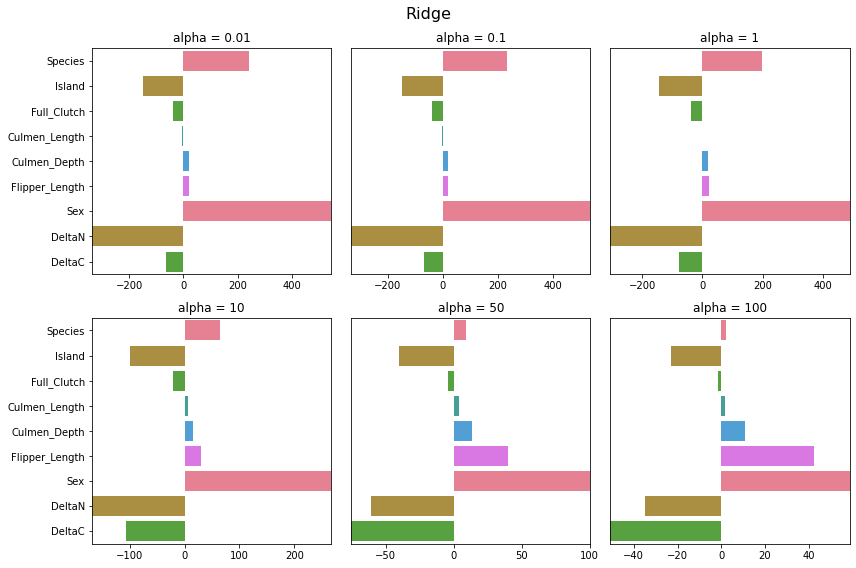

In [214]:
fig, axs = plt.subplots(2, 3, figsize = (12, 8))
colors = sns.color_palette('husl', 6)
coeff_df = pd.DataFrame()
alphas = [0.01, 0.1, 1, 10, 50, 100]

for i, alpha in enumerate(alphas):
    ridge = Ridge(alpha = alpha)
    ridge.fit(x_train, y_train)

    coeff = pd.Series(data = ridge.coef_, index = x_train.columns)
    colname = 'alpha = ' + str(alpha)
    coeff_df[colname] = coeff

    axs[i//3][i%3].set_title(colname)
    axs[i//3][i%3].set_xlim(min(coeff),max(coeff))
    sns.barplot(x = coeff.values, y = coeff.index, palette = colors, ax = axs[i//3][i%3])
    if i != 0 and i != 3:
        axs[i//3][i%3].set(yticklabels = [])   
        axs[i//3][i%3].set(ylabel = None)
        axs[i//3][i%3].tick_params(left = False)  

fig.suptitle('Ridge', fontsize = 16)
fig.tight_layout()

`-` $\alpha$가 커짐에 따라 회귀계수가 작아진다

## 라쏘 회귀(Lasso Regressor)

In [36]:
from sklearn.linear_model import Lasso

`-` $\alpha$가 커짐에 따라 계수가 $0$되는 항이 많아진다

In [175]:
alphas = [0.01, 0.1, 1, 10, 50, 100]

## alpha 값들에 대해 rmse를 구함
for alpha in alphas:
    lasso = Lasso(alpha = alpha)
    lasso.fit(x_train, y_train) ## 모델 학습
    y_predict = lasso.predict(x_valid) ## 모델 예측
    rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
    print('𝛼가 {}일 때 이 방정식의 평균 에러는 {:.2f}입니다'.format(alpha, rmse))

𝛼가 0.01일 때 이 방정식의 평균 에러는 268.00입니다
𝛼가 0.1일 때 이 방정식의 평균 에러는 267.67입니다
𝛼가 1일 때 이 방정식의 평균 에러는 264.49입니다
𝛼가 10일 때 이 방정식의 평균 에러는 255.46입니다
𝛼가 50일 때 이 방정식의 평균 에러는 311.57입니다
𝛼가 100일 때 이 방정식의 평균 에러는 327.98입니다


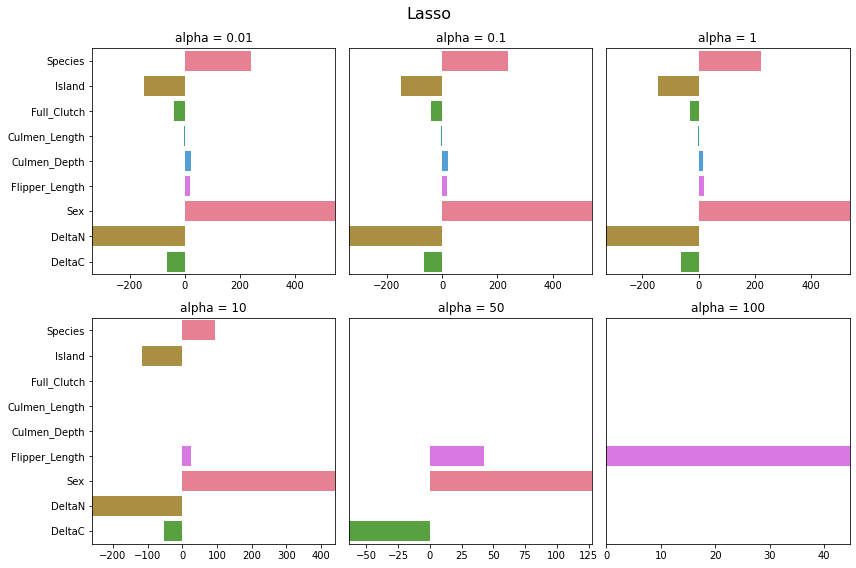

In [215]:
fig, axs = plt.subplots(2, 3, figsize = (12, 8))
colors = sns.color_palette('husl', 6)
coeff_df = pd.DataFrame()
alphas = [0.01, 0.1, 1, 10, 50, 100]

for i, alpha in enumerate(alphas):
    lasso = Lasso(alpha = alpha)
    lasso.fit(x_train, y_train)

    coeff = pd.Series(data = lasso.coef_, index = x_train.columns)
    colname = 'alpha = ' + str(alpha)
    coeff_df[colname] = coeff

    axs[i//3][i%3].set_title(colname)
    axs[i//3][i%3].set_xlim(min(coeff),max(coeff))
    sns.barplot(x = coeff.values, y = coeff.index, palette = colors, ax = axs[i//3][i%3])
    if i != 0 and i != 3:
        axs[i//3][i%3].set(yticklabels = [])   
        axs[i//3][i%3].set(ylabel = None)
        axs[i//3][i%3].tick_params(left = False)  

fig.suptitle('Lasso', fontsize = 16)
fig.tight_layout()

## 엘라스틱 넷(Elastic Net)

`-` 라쏘 회귀에서의 규제항(L1)과 릿지 회귀에서의 규제항(L2)을 비율에 따라 혼합한 규제항을 사용 

In [30]:
from sklearn.linear_model import ElasticNet

In [198]:
alphas = [0.01, 0.1, 1, 10]
L1_ratios = [0.05, 0.2, 0.5, 0.8, 0.95]
## alpha 값들에 대해 rmse를 구함
for alpha in alphas:
    for L1_ratio in L1_ratios:
        elastic_net = ElasticNet(alpha = alpha, l1_ratio = L1_ratio)
        elastic_net.fit(x_train, y_train) ## 모델 학습
        y_predict = elastic_net.predict(x_valid) ## 모델 예측
        rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
        print('𝛼가 {}이고 L1_raio가 {}일 때 이 방정식의 평균 에러는 {:.2f}입니다'.format(alpha, L1_ratio, rmse))
    print('\n', end = '')

𝛼가 0.01이고 L1_raio가 0.05일 때 이 방정식의 평균 에러는 268.85입니다
𝛼가 0.01이고 L1_raio가 0.2일 때 이 방정식의 평균 에러는 268.62입니다
𝛼가 0.01이고 L1_raio가 0.5일 때 이 방정식의 평균 에러는 268.25입니다
𝛼가 0.01이고 L1_raio가 0.8일 때 이 방정식의 평균 에러는 268.04입니다
𝛼가 0.01이고 L1_raio가 0.95일 때 이 방정식의 평균 에러는 268.00입니다

𝛼가 0.1이고 L1_raio가 0.05일 때 이 방정식의 평균 에러는 288.65입니다
𝛼가 0.1이고 L1_raio가 0.2일 때 이 방정식의 평균 에러는 285.76입니다
𝛼가 0.1이고 L1_raio가 0.5일 때 이 방정식의 평균 에러는 278.81입니다
𝛼가 0.1이고 L1_raio가 0.8일 때 이 방정식의 평균 에러는 270.86입니다
𝛼가 0.1이고 L1_raio가 0.95일 때 이 방정식의 평균 에러는 267.96입니다

𝛼가 1이고 L1_raio가 0.05일 때 이 방정식의 평균 에러는 318.07입니다
𝛼가 1이고 L1_raio가 0.2일 때 이 방정식의 평균 에러는 316.89입니다
𝛼가 1이고 L1_raio가 0.5일 때 이 방정식의 평균 에러는 313.02입니다
𝛼가 1이고 L1_raio가 0.8일 때 이 방정식의 평균 에러는 301.27입니다
𝛼가 1이고 L1_raio가 0.95일 때 이 방정식의 평균 에러는 277.80입니다

𝛼가 10이고 L1_raio가 0.05일 때 이 방정식의 평균 에러는 332.59입니다
𝛼가 10이고 L1_raio가 0.2일 때 이 방정식의 평균 에러는 331.16입니다
𝛼가 10이고 L1_raio가 0.5일 때 이 방정식의 평균 에러는 328.05입니다
𝛼가 10이고 L1_raio가 0.8일 때 이 방정식의 평균 에러는 323.53입니다
𝛼가 10이고 L1_raio가 0.95일 때 이 방정식의 평균 에러는 314.74입니다



`-` 뗑컨 데이터에 대해서는 일라스틱 넷에서 L1_ratio가 높을수록 RMSE가 작다

`-` 릿지, 라쏘와 엘라스틱 넷의 차이를 느끼고자 L1_ratio는 0.5로 하자

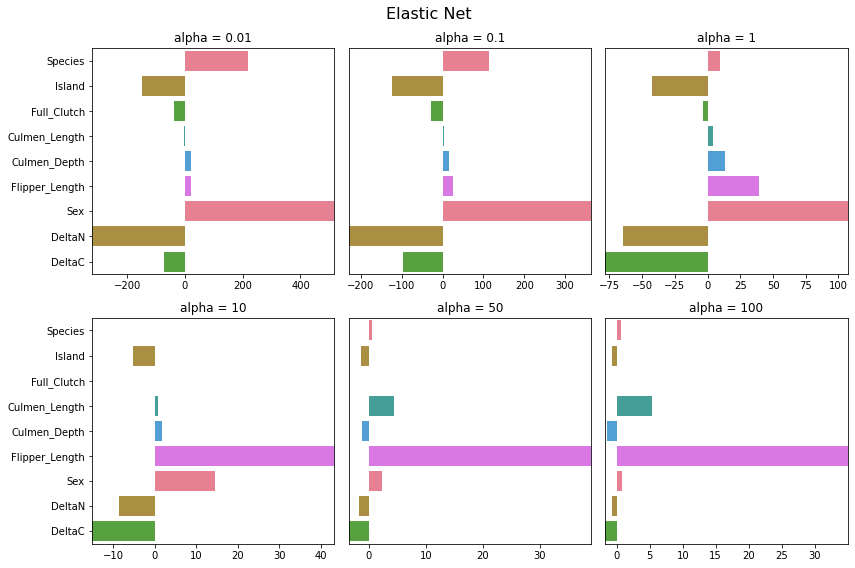

In [216]:
fig, axs = plt.subplots(2, 3, figsize = (12, 8))
colors = sns.color_palette('husl', 6)
coeff_df = pd.DataFrame()
alphas = [0.01, 0.1, 1, 10, 50, 100]

for i, alpha in enumerate(alphas):
    elastic_net = ElasticNet(alpha = alpha)
    elastic_net.fit(x_train, y_train)

    coeff = pd.Series(data = elastic_net.coef_, index = x_train.columns)
    colname = 'alpha = ' + str(alpha)
    coeff_df[colname] = coeff

    axs[i//3][i%3].set_title(colname)
    axs[i//3][i%3].set_xlim(min(coeff),max(coeff))
    sns.barplot(x = coeff.values, y = coeff.index, palette = colors, ax = axs[i//3][i%3])
    if i != 0 and i != 3:
        axs[i//3][i%3].set(yticklabels = [])   
        axs[i//3][i%3].set(ylabel = None)
        axs[i//3][i%3].tick_params(left = False)  

fig.suptitle('Elastic Net', fontsize = 16)
fig.tight_layout()

`-` 회귀계수들이 작아지고 계수가 $0$인 변수도 존재한다

## 라쏘 회귀 + 교호작용 + 표준화

`-` EDA에서는 특별히 교호작용항 추가의 필요성을 느끼지 못했는데 이를 라쏘 회귀를 통해 확인하자

### 교호작용항 추가

In [41]:
numeric_features = df.columns[(df.dtypes == np.int64) | (df.dtypes == float)][:-1]
categorical_features = df.columns[df.dtypes == 'O']

In [39]:
def poly(df):
    df2 = df.copy()
    for categorical_feature in categorical_features:
        if categorical_feature in df2.columns:
            for numeric_feature in numeric_features:
                if numeric_feature in df2.columns:
                    df2[categorical_feature + '_' + numeric_feature] = df2[categorical_feature] * df2[numeric_feature]
    return df2

In [50]:
x_poly_train = poly(x_train)
x_poly_valid = poly(x_valid)

In [51]:
x_train.shape, x_poly_train.shape  ## 교호작용항을 추가하니 피쳐의 수가 9에서 29로 늘어났다

((91, 9), (91, 29))

### 표준화

`-` 위의 교호작용항을 추가한 train, valid 셋을 표준화해주자

In [52]:
from sklearn.preprocessing import StandardScaler

## 스케일러 생성
standard_scaler = StandardScaler()

## 트레인집합 정규화
x_poly_train_scaled = standard_scaler.fit_transform(x_poly_train)
x_poly_train_scaled_df = pd.DataFrame(data = x_poly_train_scaled, columns = x_poly_train.columns)

## 테스트집합 정규화
x_poly_valid_scaled = standard_scaler.transform(x_poly_valid) ## x_train에서 학습한 정규화방식을 그대로 x_valid에 적용
x_poly_valid_scaled_df = pd.DataFrame(data = x_poly_valid_scaled, columns = x_poly_valid.columns)

### 라쏘 회귀

`-` $\alpha$에 따른 rmse를 구해보자

In [31]:
alphas = [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for alpha in alphas:
    lasso = Lasso(alpha = alpha, max_iter = 20000, random_state = 21)
    lasso.fit(x_poly_train_scaled_df, y_train)
    y_predict = lasso.predict(x_poly_valid_scaled_df) ## 모델 예측
    rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
    print('𝛼가 {}일 때 이 방정식의 평균 에러는 {:.2f}입니다'.format(alpha, rmse))

𝛼가 0.3일 때 이 방정식의 평균 에러는 224.92입니다
𝛼가 0.5일 때 이 방정식의 평균 에러는 237.58입니다
𝛼가 0.6일 때 이 방정식의 평균 에러는 243.05입니다
𝛼가 0.7일 때 이 방정식의 평균 에러는 246.01입니다
𝛼가 0.8일 때 이 방정식의 평균 에러는 248.03입니다
𝛼가 0.9일 때 이 방정식의 평균 에러는 250.25입니다
𝛼가 0.99일 때 이 방정식의 평균 에러는 252.43입니다


`-` $\alpha$가 작다는것은 규제를 적게 한다는 의미 ---> 오버피팅 가능성 높아짐

`-` 피쳐수도 29개라 $\alpha$를 크게하는것이 일반화에 좋을 것 임

`-` $\alpha$값으로 $0.7$을 선택하자

In [42]:
lasso_07 = Lasso(alpha = 0.7, max_iter = 20000, random_state = 21)
lasso_07.fit(x_poly_train_scaled_df, y_train)
train_predict = lasso_07.predict(x_poly_train_scaled_df) ## train 예측값 
residuals = y_train - train_predict ## 잔차 = 실제값 - 예측값  

`-` 잔차와 적합치 그림

Text(0.5, 1.0, 'fitted vs residual')

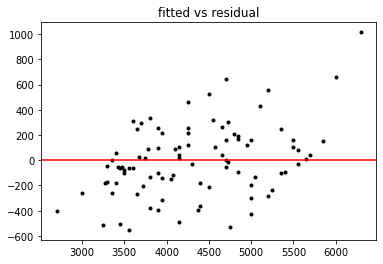

In [43]:
plt.plot(y_train, residuals, '.k')
plt.axhline(0, 0.0, 1.0, color = 'red')
plt.title('fitted vs residual')

`-` 나쁘지 않은 것 같다

`-` 잔차의 히스토그램

<AxesSubplot:>

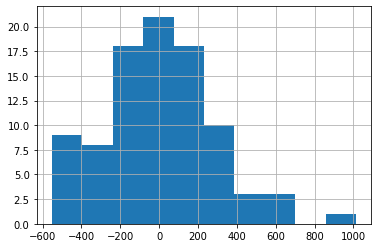

In [44]:
residuals.hist()

`-` 종모양이고 이상점이 있긴한데 개수가 적어서 괜찮은 것 같다

### 라쏘 회귀 최적$\alpha$ 선택

`-` train rmse, test rmse 시각화

In [67]:
train_rmse_list, valid_rmse_list = [], []
alphas = np.linspace(0.01, 0.99, 100)

for alpha in alphas:
    lasso = Lasso(alpha = alpha, max_iter = 150000, random_state = 21)
    lasso.fit(x_poly_train_scaled_df, y_train)
    
    train_predict = lasso.predict(x_poly_train_scaled_df) ## 훈련집합 예측
    y_predict = lasso.predict(x_poly_valid_scaled_df) ## valid셋 예측
    
    train_rmse = RMSE(train_predict, y_train)
    valid_rmse = RMSE(y_predict, y_valid)
    train_rmse_list.append(train_rmse)
    valid_rmse_list.append(valid_rmse)

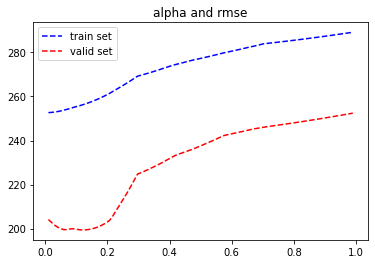

In [71]:
plt.plot(alphas, train_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, valid_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

`-` 훈련 집합에 대해서는 $\alpha$가 작을수록 RMSE가 작다

`-` 테스트 집합에 대해서는 $\alpha = 0.1$일 때 RMSE가 가장 작고 증가한다

`-` 최적 $\alpha$값은 $0.7$ 부근인 것 같다(train 그래프와 valid 그래프 사이의 거리가 가장 작은 지점으로 골랐음(나도 이유 모름))

## 라쏘 회귀 + 교호작용 + 표준화 + 하이퍼 파라미터 깎기

`-` 어떤 피쳐를 포함하는 것이 좋을지와 $\alpha$를 무엇으로 정할지를 고려하자

`-` 일단 내 생각엔 Full_clutch는 필요없고 Species가 있으면 Island도 필요없다

`-` Species와 Island 둘 다 있으면 과적합이 될 것 같다

### Full_Clutch와 Island 드랍

In [136]:
x_train2 = x_train.drop(['Full_Clutch', 'Island'], axis = 1)
x_valid2 = x_valid.drop(['Full_Clutch', 'Island'], axis = 1)

`-` 교호작용항을 추가하자

In [137]:
x_poly_train2 = poly(x_train2)
x_poly_valid2 = poly(x_valid2)

In [138]:
## 스케일러 생성
standard_scaler = StandardScaler()

## 트레인집합 정규화
x_poly_train2_scaled = standard_scaler.fit_transform(x_poly_train2)
x_poly_train2_scaled_df = pd.DataFrame(data = x_poly_train2_scaled, columns = x_poly_train2.columns)

## 테스트집합 정규화
x_poly_valid2_scaled = standard_scaler.transform(x_poly_valid2) ## x_train에서 학습한 정규화방식을 그대로 x_valid에 적용
x_poly_valid2_scaled_df = pd.DataFrame(data = x_poly_valid2_scaled, columns = x_poly_valid2.columns)

`-` $\alpha$ 선택

In [139]:
alphas = [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for alpha in alphas:
    lasso = Lasso(alpha = alpha, max_iter = 20000, random_state = 21)
    lasso.fit(x_poly_train2_scaled_df, y_train)
    y_predict = lasso.predict(x_poly_valid2_scaled_df) ## 모델 예측
    rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
    print('𝛼가 {}일 때 이 방정식의 평균 에러는 {:.2f}입니다'.format(alpha, rmse))

𝛼가 0.3일 때 이 방정식의 평균 에러는 254.64입니다
𝛼가 0.5일 때 이 방정식의 평균 에러는 257.47입니다
𝛼가 0.6일 때 이 방정식의 평균 에러는 257.00입니다
𝛼가 0.7일 때 이 방정식의 평균 에러는 256.63입니다
𝛼가 0.8일 때 이 방정식의 평균 에러는 256.14입니다
𝛼가 0.9일 때 이 방정식의 평균 에러는 255.70입니다
𝛼가 0.99일 때 이 방정식의 평균 에러는 255.39입니다


`-` Full_Clutch와 Island 드랍하지 않은 모델과 비교하면 rmse가 더 크다

`-` 하지만 $\alpha$값 변화에 따른 rmse의 변화폭은 훨씩 작기에 일반화 능력은 더 좋은 것 같다

`-` 최적의 $\alpha$값을 선택해보자

In [104]:
train2_rmse_list, valid2_rmse_list = [], []
alphas = np.linspace(0.01, 0.99, 100)

for alpha in alphas:
    lasso = Lasso(alpha = alpha, max_iter = 150000, random_state = 21)
    lasso.fit(x_poly_train2_scaled_df, y_train)
    
    train_predict = lasso.predict(x_poly_train2_scaled_df) ## 훈련집합 예측
    y_predict = lasso.predict(x_poly_valid2_scaled_df) ## valid셋 예측
    
    train_rmse = RMSE(train_predict, y_train)
    valid_rmse = RMSE(y_predict, y_valid)
    train2_rmse_list.append(train_rmse)
    valid2_rmse_list.append(valid_rmse)

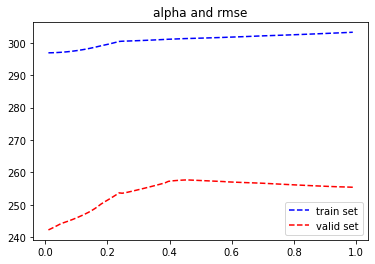

In [105]:
plt.plot(alphas, train2_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, valid2_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

`-` $\alpha = 0.4$일 때가 최적으로 보인다

In [140]:
lasso_04 = Lasso(alpha = 0.4, max_iter = 150000, random_state = 21)
lasso_04.fit(x_poly_train2_scaled_df, y_train) ## 라쏘 회귀모형을 train셋을 이용해 학습시킨다

Lasso(alpha=0.4, max_iter=150000, random_state=21)

In [141]:
train_predict = lasso_04.predict(x_poly_train2_scaled_df) ## train셋을 통해 학습된 모델을 통해 train셋을 예측

In [142]:
residuals = y_train - train_predict ## 잔차 = 실제값 - 예측값  

`-` 잔차와 적합치 그림

Text(0.5, 1.0, 'fitted vs residual')

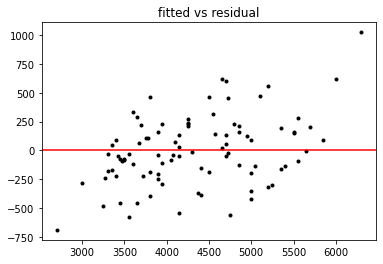

In [48]:
plt.plot(y_train, residuals, '.k')
plt.axhline(0, 0.0, 1.0, color = 'red')
plt.title('fitted vs residual')

`-` 이상점이 하나 있긴 하지만 나쁘지 않은 것 같다

`-` 잔차의 히스토그램

<AxesSubplot:>

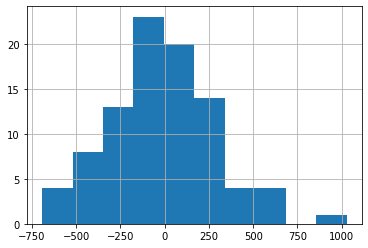

In [49]:
residuals.hist()

`-` 이상점 하나를 제외하면 아름다운 종모양이다

`-` 평균이 $0$이고 표준편차 $250$정도인 정규분포 모양

### Full_Clutch 드랍

In [99]:
x_train3 = x_train.drop('Full_Clutch', axis = 1)
x_valid3 = x_valid.drop('Full_Clutch', axis = 1)

`-` 교호작용항을 추가하자

In [102]:
x_poly_train3 = poly(x_train3)
x_poly_valid3 = poly(x_valid3)

In [143]:
## 스케일러 생성
standard_scaler = StandardScaler()

## 트레인집합 정규화
x_poly_train3_scaled = standard_scaler.fit_transform(x_poly_train3)
x_poly_train3_scaled_df = pd.DataFrame(data = x_poly_train3_scaled, columns = x_poly_train3.columns)

## 테스트집합 정규화
x_poly_valid3_scaled = standard_scaler.transform(x_poly_valid3) ## x_train에서 학습한 정규화방식을 그대로 x_valid에 적용
x_poly_valid3_scaled_df = pd.DataFrame(data = x_poly_valid3_scaled, columns = x_poly_valid3.columns)

`-` 최적의 $\alpha$값을 선택해보자

In [108]:
train3_rmse_list, valid3_rmse_list = [], []
alphas = np.linspace(0.01, 0.99, 100)

for alpha in alphas:
    lasso = Lasso(alpha = alpha, max_iter = 150000, random_state = 21)
    lasso.fit(x_poly_train3_scaled_df, y_train)
    
    train_predict = lasso.predict(x_poly_train3_scaled_df) ## 훈련집합 예측
    y_predict = lasso.predict(x_poly_valid3_scaled_df) ## valid셋 예측
    
    train_rmse = RMSE(train_predict, y_train)
    valid_rmse = RMSE(y_predict, y_valid)
    train3_rmse_list.append(train_rmse)
    valid3_rmse_list.append(valid_rmse)

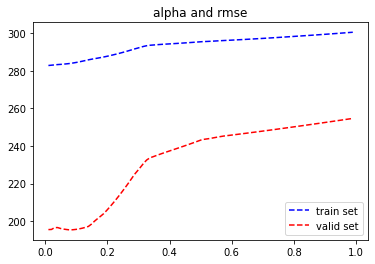

In [109]:
plt.plot(alphas, train3_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, valid3_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

`-` 변수를 드랍하지 않고 라쏘 회귀를 돌린 모형과 비슷한 그래프를 보인다

`-` $\alpha = 0.7$일 때가 최적으로 보인다

`-` 눈대중 말고 정확히 구하자

In [115]:
optimal_alpha = pd.DataFrame({'alpha':alphas, 'train_rmse':train3_rmse_list, 'valid_rmse':valid3_rmse_list})

In [120]:
optimal_alpha.eval('rmse_interval = train_rmse - valid_rmse').\
sort_values('rmse_interval').iloc[0,:]

alpha              0.990000
train_rmse       300.623132
valid_rmse       254.692353
rmse_interval     45.930779
Name: 99, dtype: float64

`-` 0.99일 때가 제일 간격이 작다

`-` 그런데 내가 최대값을 0.99로 설정해서 그렇지 아마 1일 때가 간격이 제일 작을 듯 싶다

## 릿지 회귀와 엘라스틱 넷 찍먹

### 릿지 회귀

`-` 라쏘 회귀만 하기엔 아쉬우니 릿지 회귀도 해보자

In [291]:
alphas = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
for alpha in alphas:
    ridge = Ridge(alpha = alpha, max_iter = 20000, random_state = 21)
    ridge.fit(x_poly_train_scaled_df, y_train)
    y_predict = ridge.predict(x_poly_valid_scaled_df) ## 모델 예측
    rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
    print('𝛼가 {}일 때 이 방정식의 평균 에러는 {:.2f}입니다'.format(alpha, rmse))

𝛼가 0.1일 때 이 방정식의 평균 에러는 238.11입니다
𝛼가 0.3일 때 이 방정식의 평균 에러는 246.98입니다
𝛼가 0.5일 때 이 방정식의 평균 에러는 251.14입니다
𝛼가 0.7일 때 이 방정식의 평균 에러는 253.86입니다
𝛼가 0.9일 때 이 방정식의 평균 에러는 255.86입니다
𝛼가 0.99일 때 이 방정식의 평균 에러는 256.60입니다


`-` 라쏘 회귀보다 평균 에러가 더 높게 나온다

### 엘라스틱 넷

In [297]:
alphas = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
for alpha in alphas:
    elastic_net = ElasticNet(alpha = alpha, l1_ratio = 0.5, max_iter = 20000, random_state = 21)
    elastic_net.fit(x_poly_train_scaled_df, y_train)
    y_predict = elastic_net.predict(x_poly_valid_scaled_df) ## 모델 예측
    rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
    print('𝛼가 {}일 때 이 방정식의 평균 에러는 {:.2f}입니다'.format(alpha, rmse))

𝛼가 0.1일 때 이 방정식의 평균 에러는 266.97입니다
𝛼가 0.3일 때 이 방정식의 평균 에러는 271.54입니다
𝛼가 0.5일 때 이 방정식의 평균 에러는 273.53입니다
𝛼가 0.7일 때 이 방정식의 평균 에러는 275.26입니다
𝛼가 0.9일 때 이 방정식의 평균 에러는 277.16입니다
𝛼가 0.99일 때 이 방정식의 평균 에러는 278.10입니다


`-` 성능은 라쏘 > 릿지 > 엘라스틱 넷

### test 예측

`-` 성능이 가장 좋게 나온 라쏘 회귀 모형을 통해 test 데이터를 예측하자

`-` Full_Clutch와 Island를 드랍하고 교호작용을 추가한 데이터를 사용하자

`-` $\alpha = 0.4$인 라쏘 모델을 사용하자

In [159]:
test = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/test.csv')
test.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,0,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,52.0,20.7,210.0,MALE,9.43146,-24.68440
1,1,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,55.9,17.0,228.0,MALE,8.31180,-26.35425
2,2,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,38.9,18.8,190.0,FEMALE,8.36936,-26.11199
3,3,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,45.2,16.6,191.0,FEMALE,9.62357,-24.78984
4,4,Adelie Penguin (Pygoscelis adeliae),Biscoe,No,37.9,18.6,172.0,FEMALE,8.38404,-25.19837


In [160]:
test.isnull().sum()

id                     0
Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    6
Delta 15 N (o/oo)      9
Delta 13 C (o/oo)      8
dtype: int64

In [161]:
test['Delta 15 N (o/oo)'].fillna(dt['DeltaN'].median(), inplace = True) ## train셋의 중앙값을 대입
test['Delta 13 C (o/oo)'].fillna(dt['DeltaC'].median(), inplace = True) ## train셋의 평균을 대입

In [162]:
test.rename(columns = {'Clutch Completion':'Full_Clutch', 'Culmen Length (mm)':'Culmen_Length', 
                     'Culmen Depth (mm)':'Culmen_Depth', 'Flipper Length (mm)':'Flipper_Length',
                     'Delta 15 N (o/oo)':'DeltaN', 'Delta 13 C (o/oo)':'DeltaC', 'Body Mass (g)':'Body_Mass'}, inplace = True) ## 편의상 열 이름 변경

In [163]:
test.loc[[46,81,98,152,205,209], 'Sex'] = ['FEMALE'] * 6 ## train셋과 비교하여 몸무게와 상관관계가 큰 날개 길이가 작아 암컷으로 넣어줌 

In [164]:
test.drop('id', axis = 1, inplace = True) ## id는 필요없으니 드랍

`-` test 셋도 범주형변수에 대해 라벨 인코딩을 해주자

In [35]:
# test2 = test.copy()
# for col in test2.columns:
#     if test2.dtypes[col] == 'O':
#         encoder = LabelEncoder()
#         encoder.fit(test2[col])
#         labels = encoder.transform(test2[col])
#         test2[col] = list(labels) 

`-` 위랑 아래랑 똑같음!

`-` train에서 fit한 라벨인코딩을 사용하여 test셋을 transform하자

In [165]:
test2 = test.copy()

In [166]:
test2.drop(['Island', 'Full_Clutch'], axis = 1, inplace = True)

In [167]:
test_species_labels = species_encoder.transform(test2['Species'])
test2['Species'] = list(test_species_labels) ## Species labelencoding

# test_island_labels = island_encoder.transform(test2['Island'])
# test2['Island'] = list(test_island_labels) ## Island labelencoding

# test_full_clutch_labels = full_clutch_encoder.transform(test2['Full_Clutch'])
# test2['Full_Clutch'] = list(test_full_clutch_labels) ## Full_Clutch labelencoding

test_sex_labels = sex_encoder.transform(test2['Sex'])
test2['Sex'] = list(test_sex_labels) ## Sex labelencoding

In [168]:
test2.head()

,Species,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,1,52.0,20.7,210.0,1,9.43146,-24.68440
1,2,55.9,17.0,228.0,1,8.31180,-26.35425
2,0,38.9,18.8,190.0,0,8.36936,-26.11199
3,1,45.2,16.6,191.0,0,9.62357,-24.78984
4,0,37.9,18.6,172.0,0,8.38404,-25.19837


`-` 라벨 인코딩이 잘 되었다

`-` 교호작용항을 추가해주자

In [169]:
test_poly = poly(test2)

In [170]:
test_poly.shape

(228, 17)

`-` 위에서 train셋을 이용해 학습한 스케일러의 평균과 표준편차

In [129]:
## 테스트집합 정규화
test_poly_scaled = standard_scaler.transform(test_poly) ## x_train에서 학습한 정규화방식을 그대로 test_poly에 적용
test_poly_scaled_df = pd.DataFrame(data = test_poly_scaled, columns = test_poly.columns)

In [64]:
test_poly_scaled_df.iloc[:6, :6] ## 정규화가 잘 되었는지 확인

,Species,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN
0,-0.062325,1.352166,1.827049,0.475402,0.946485,1.248746
1,1.071989,2.067983,-0.043329,1.717361,0.946485,-0.779539
2,-1.196639,-1.052245,0.866585,-0.904552,-1.056541,-0.675268
3,-0.062325,0.104075,-0.245532,-0.835555,-1.056541,1.596757
4,-1.196639,-1.235788,0.765483,-2.146511,-1.056541,-0.648675
5,-0.062325,1.480646,1.372092,-0.421568,0.946485,0.478778


`-` 이제 예측을 하자

In [65]:
predict_test = lasso_04.predict(test_poly_scaled_df) ## train셋을 통해 학습된 모델을 통해 test셋을 예측

# 예측 결과를 확인
predict_test[:6]

array([4292.43478938, 5644.7010042 , 3629.57759285, 3398.53498446,
       3355.05669231, 4143.32128426])

`-` 피쳐네임과 회귀계수 값을 함께 봐보자

In [71]:
list(zip(test_poly_scaled_df, lasso_04.coef_))

[('Species', 0.0),
 ('Culmen_Length', 24.848732652465234),
 ('Culmen_Depth', 79.43041730143314),
 ('Flipper_Length', 146.63116217098397),
 ('Sex', 443.64801316387513),
 ('DeltaN', -66.56675817740579),
 ('DeltaC', -71.17941002407247),
 ('Species_Culmen_Length', 568.1609963555894),
 ('Species_Culmen_Depth', -214.64866329946864),
 ('Species_Flipper_Length', 1217.2231087830062),
 ('Species_DeltaN', -1111.6009737482907),
 ('Species_DeltaC', -0.0),
 ('Sex_Culmen_Length', -427.40110849530294),
 ('Sex_Culmen_Depth', -22.150135494133274),
 ('Sex_Flipper_Length', 208.7342952529078),
 ('Sex_DeltaN', -0.0),
 ('Sex_DeltaC', -0.0)]

### dacon 대회에 제출하기

In [175]:
# 제출용 sample 파일을 불러옴
submission = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/sample_submission.csv')

In [73]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = predict_test

# 데이터가 잘 들어갔는지 확인
submission.head()

,id,Body Mass (g)
0,0,4292.434789
1,1,5644.701004
2,2,3629.577593
3,3,3398.534984
4,4,3355.056692


In [179]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission_04.csv', index = False)

`-` 점수는 261.4589133342

`-` 근데 내가 test셋 방사성 동위원소 결측치를 중앙값으로 채워야되는데 평균으로 채웠음

`-` 중앙값으로 채운것은 점수가 위와 다르겠지만 큰 차이는 없을 듯

`-` 일단 EDA를 통해 Full_Clutch는 유의미하지 않은 것을 확인했다

`-` 그리고 Species와 Island 각각에 대해서 뗑컨 피쳐들의 산점도가 그룹화 되어있었다 

`-` 이를 보고 Species와 Island 둘 중 하나만 피쳐로 사용하는 것이 좋다고 생각했고

`-` 직관적으로 보기엔 Island보다 Speices가 뗑컨 몸무게와 더 관련있다 생각했다

`-` Island와 뗑컨 몸무게 사이에는 중첩 변수가 존재한다고 생각했음

`-` 아무튼 그래서 Island와 Full_Clutch를 제거했는데 일반화능력이 그렇지 않은 것보다 좋게 나왔다